## Compute corrected sea surface heights & anomalies from Sentinel-3 ##

note that a "ssha" field is provided within the data file; however, it is interesting to know how it is computed. 

** Import libraries and define input data **

In [1]:
import os
import numpy as np
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import dates
%matplotlib inline
from mpl_toolkits.basemap import Basemap

plt.rcParams["figure.figsize"] = (16,10)
plt.ioff()

input_root = '../data/'
input_path = 'S3A_SR_2_WAT____20170809T144623_20170809T153306_20170904T084235_2802_021_025______MAR_O_NT_002.SEN3'
input_file = 'standard_measurement.nc'
#input_file = 'reduced_measurement.nc'
#input_file = 'enhanced_measurement.nc'
my_file    = os.path.join(input_root,input_path,input_file)
nc = Dataset(my_file, 'r')

** define the variables to use **

NB. corrected sea surface height =<br>
Altitude - range<br>       - atmosphere propagation corrections (dry & wet troposphere, electrons in the ionosphere)<br>        - tides (ocean, solid earth and pole)<br>       - atmospheric loading (pressure & hf winds)<br>       - sea state bias

then, depending on the reference you want to work with respect to, you can also remove either mean sea surface (SLAs) or geoid (ADT), or nothing (SSH with respect to the ellipsoid).  For ADT, you can also add the mean topography instead of removing the geoid.

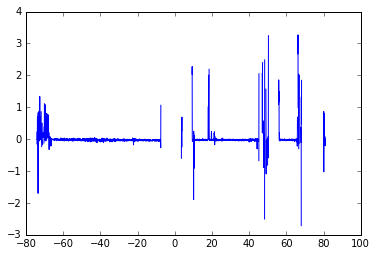

In [2]:
#below we define the variables we need to compute a corrected sea surface height and anomalies
#the computation here is done with 1 Hz data with corrections dedicated to open ocean; 
#"_plrm" variables from a dedicated processing which mimics the conventional altimetry are proposed, 
# but if you use them, use them systematically whenever available, don't mix.
#Over coastal areas some correction fields would be different, such as the wet tropospheric correction (not from radiometer)
#Some corrections are only provided at 1Hz, since their resolution can't be higher, but they still must be applied for a 
#computation at 20 Hz, though. So you have to use 20 times the 1 Hz value. 

lat = nc.variables['lat_01'][:]
lon = nc.variables['lon_01'][:]
range_ku = nc.variables['range_ocean_01_ku'][:]
alt = nc.variables['alt_01'][:]
#atmosphere propagation corrections
model_dry_tropo_corr = nc.variables['mod_dry_tropo_cor_meas_altitude_01'][:]
rad_wet_tropo_corr = nc.variables['rad_wet_tropo_cor_01_ku'][:]
iono_corr_alt_ku = nc.variables['iono_cor_alt_01_ku'][:]
#tides
ocean_tide_sol1 = nc.variables['ocean_tide_sol1_01'][:]
solid_earth_tide = nc.variables['solid_earth_tide_01'][:]
pole_tide = nc.variables['pole_tide_01'][:]
#atmospheric loading, sea state bias
hf_fluctuations_corr = nc.variables['hf_fluct_cor_01'][:]
inv_bar_corr = nc.variables['inv_bar_cor_01'][:]
sea_state_bias_ku = nc.variables['sea_state_bias_01_ku'][:]
#reference surfaces
mean_sea_surface = nc.variables['mean_sea_surf_sol1_01'][:]
mean_topography = nc.variables['mean_dyn_topo_01'] [:]
geoid = nc.variables['geoid_01'] [:]

#visualize the variables above
fig = plt.figure()
plt.plot(lat, iono_corr_alt_ku)
#plt.plot(lat, model_dry_tropo_corr)
#plt.plot(lat, rad_wet_tropo_corr)
#plt.plot(lat, ocean_tide_sol1)
#plt.plot(lat, solid_earth_tide)
#plt.plot(lat, pole_tide)
#plt.plot(lat, hf_fluctuations_corr)
#plt.plot(lat, inv_bar_corr)
#plt.plot(lat, sea_state_bias_ku)
plt.show()

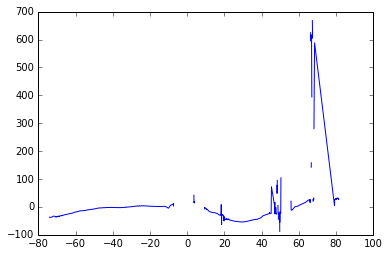

In [3]:
# here are intermediate computation steps of ssh and sla (though there is no order to apply the corrections)
# usually, only the full corrected ones are used, except if e.g. some need to be replaced by local equivalents
# the idea here is that you get a concrete idea of the impact of each of them
raw_ssh = alt - range_ku
raw_sla = (alt - range_ku) - mean_sea_surface
sla_ionocorr = ((alt - range_ku) - mean_sea_surface) - iono_corr_alt_ku
sla_iono_drytropocorr = sla_ionocorr - model_dry_tropo_corr
sla_iono_radtropocorr = sla_iono_drytropocorr - rad_wet_tropo_corr
tides = (ocean_tide_sol1 - solid_earth_tide) - pole_tide
sla_iono_tropo_tides_corr = sla_iono_radtropocorr - tides
sla_iono_tropo_tides_ssb_corr = sla_iono_tropo_tides_corr - sea_state_bias_ku
dynatmcorr = hf_fluctuations_corr + inv_bar_corr
sla_fullcorr = sla_iono_tropo_tides_ssb_corr - dynatmcorr
adt = sla_fullcorr + mean_topography

#plot e.g. a "raw" version of SSH (un-corrected)
lat = nc.variables['lat_01'][:]
fig = plt.figure()
plt.plot(lat, raw_ssh)
plt.show()

Note the amplitude, and note also the very extreme data.

** have a look at the SLA **

note the same - amplitude, and the extreme data

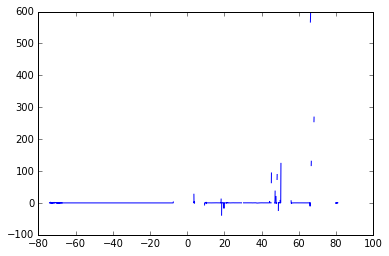

In [4]:
#or corrected sla
lat = nc.variables['lat_01'][:]
fig = plt.figure()
plt.plot(lat, sla_fullcorr)
plt.show()

** looking at a major current **
the graph above shows a whole track (half orbit); a smaller area can be easier to interpret. We will focus on the North Atlantic (Gulf Stream), i.e. restrict the graph to a latitude between 0 and 45°N. 
You may need to adapt the axis to the area/date you are looking at. Zoom over another region and look at the extrema values


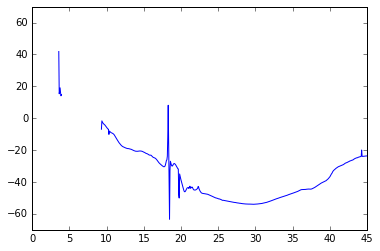

In [5]:
# zoom on an area and adapt the scale 
lat = nc.variables['lat_01'][:]
fig = plt.figure()
plt.plot(lat, raw_ssh)
# modify the third and fourth values below to adapt the y scale (NB. we are working in meters, for raw ssh)
plt.axis([0, 45, -70, 70])
plt.show()

** tests on the variables over the Gulf Stream area **
Try and test different variables as defined above - corrections and intermediate ssh values
modify the min/max in y to better see the amplitude of the curves
ends up with sla_fullcorr

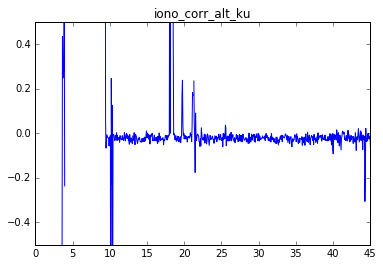

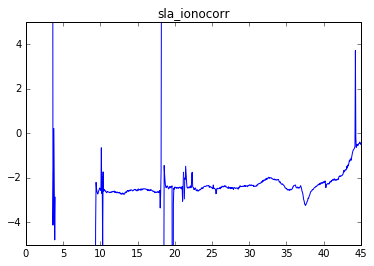

In [6]:
lat = nc.variables['lat_01'][:]
fig1 = plt.figure()
plt.plot(lat, iono_corr_alt_ku)
plt.title('iono_corr_alt_ku')
plt.axis([0, 45, -0.5, 0.5])

fig2 = plt.figure()
plt.plot(lat, sla_ionocorr)
plt.title('sla_ionocorr')
plt.axis([0, 45, -5, 5])
plt.show()

** "Editing" **

The data with extreme values do not seem relevant - sea level anomalies of more than 100 meters are not possible. Thus, to use the data, you need to remove the spurious ones. 
Two processes can be used : using the provided flags, or using physical thresholds (using the limitation of the physics or of the algorithms).

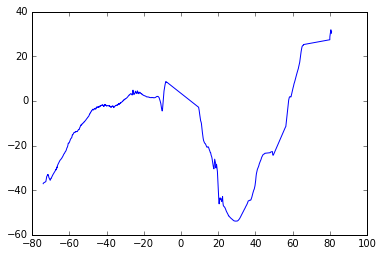

In [7]:
#remove spurious data by "editing" using threshold  values (plus surface type)
surface_type = nc.variables['surf_type_01'][:]
swh_ku = nc.variables['swh_ocean_01_ku'][:]
sig0_ku = nc.variables['sig0_ocean_01_ku'][:]
wind_speed_alt = nc.variables['wind_speed_alt_01_ku'][:]

mask = (surface_type == 0) & (model_dry_tropo_corr > -2.5) & (model_dry_tropo_corr < -1.9) & (rad_wet_tropo_corr > -0.500) & (rad_wet_tropo_corr < -0.001) & (iono_corr_alt_ku > -0.400) & (iono_corr_alt_ku < 0.040) & (sea_state_bias_ku > -0.500) & (sea_state_bias_ku < 0) & (ocean_tide_sol1 > -5) & (ocean_tide_sol1 < 5) & (solid_earth_tide > -1) & (solid_earth_tide < 1) & (pole_tide > -0.150) & (pole_tide < 0.150) & (swh_ku > 0) & (swh_ku < 11) & (sig0_ku > 7) & (sig0_ku < 30) & (wind_speed_alt > 0) & (wind_speed_alt < 30) & ((alt-range_ku) > -130) & ((alt-range_ku) < 100) & (( hf_fluctuations_corr + inv_bar_corr) > -2) & (( hf_fluctuations_corr + inv_bar_corr) < 2) &  (sla_fullcorr > -2) & (sla_fullcorr < 2)
sshedited = raw_ssh[mask]
fig = plt.figure()
plt.plot(lat[mask], raw_ssh[mask])
plt.show()

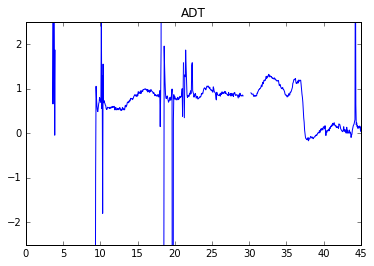

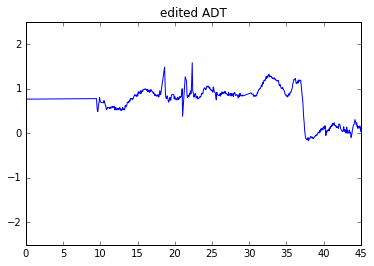

In [8]:
#now, test the "adt" (ssh with respect to the geoid)
lat = nc.variables['lat_01'][:]
fig1 = plt.figure()
plt.plot(lat, adt)
plt.title('ADT')
plt.axis([0, 45, -2.5, 2.5])

mask = (surface_type == 0) & (model_dry_tropo_corr > -2.5) & (model_dry_tropo_corr < -1.9) & (rad_wet_tropo_corr > -0.500) & (rad_wet_tropo_corr < -0.001) & (iono_corr_alt_ku > -0.400) & (iono_corr_alt_ku < 0.040) & (sea_state_bias_ku > -0.500) & (sea_state_bias_ku < 0) & (ocean_tide_sol1 > -5) & (ocean_tide_sol1 < 5) & (solid_earth_tide > -1) & (solid_earth_tide < 1) & (pole_tide > -0.150) & (pole_tide < 0.150) & (swh_ku > 0) & (swh_ku < 11) & (sig0_ku > 7) & (sig0_ku < 30) & (wind_speed_alt > 0) & (wind_speed_alt < 30) & ((alt-range_ku) > -130) & ((alt-range_ku) < 100) & (( hf_fluctuations_corr + inv_bar_corr) > -2) & (( hf_fluctuations_corr + inv_bar_corr) < 2) &  (sla_fullcorr > -2) & (sla_fullcorr < 2)
adtedited = adt[mask]
fig = plt.figure()
plt.plot(lat[mask], adt[mask])
plt.title('edited ADT')
plt.axis([0, 45, -2.5, 2.5])
plt.show()

You can apply the computation to a whole cycle or a regional area of a whole cycle and map it.
Note that if you mix SLA computed like this from several satellites (see the Jason-3 equivalent notebook for example), you will have biases and other differences between them. 
